In [30]:
# General libraries
import pandas as pd
import numpy as np
from collections import defaultdict
import random
from random import randrange
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Libraries for developing a Neural Network
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import to_categorical 

from sklearn.metrics import roc_auc_score


In [2]:
dataset = pd.read_csv("../data_models/dataset7.csv", sep='\t')

In [3]:
# Shuffle the data set
dataset = dataset.sample(frac=1).reset_index(drop=True)
# Filling NaN values with zeros. Not sure if it is correct.
dataset['Com_Followings_Ratio'] = dataset['Com_Followings_Ratio'].fillna(0)
dataset = dataset.replace([np.inf],1000)

In [4]:
dataset.isna().any()

Source                     False
Sink                       False
Source_Followings          False
Source_Followers           False
Sink_Followers             False
Distance                   False
Real                       False
Common_Followings          False
Com_Followings_Ratio       False
Followers_Ratio            False
Indirect_Followings        False
Inv_Indirect_Followings    False
Source_friends_num         False
friends_cycle_num          False
SourceFollowersToSink      False
dtype: bool

In [5]:
dataset.isin([np.inf]).any()

Source                     False
Sink                       False
Source_Followings          False
Source_Followers           False
Sink_Followers             False
Distance                   False
Real                       False
Common_Followings          False
Com_Followings_Ratio       False
Followers_Ratio            False
Indirect_Followings        False
Inv_Indirect_Followings    False
Source_friends_num         False
friends_cycle_num          False
SourceFollowersToSink      False
dtype: bool

In [23]:
msk = np.random.rand(len(dataset)) < 0.8

Y = dataset['Real']
X = dataset.drop(columns=['Real','Sink','Source'])

# Normalization
X = (X-X.min())/(X.max()-X.min())

X_train = X[msk]
X_test = X[~msk]
Y_train = Y[msk]
Y_test = Y[~msk]

In [7]:
def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [34]:
# Model arguments
args = dict(x = X_train,
            y = Y_train,
            epochs=20,
            validation_split=0.2,
            verbose=2,
            shuffle=True)

# Layer definition
input_layer = Input(shape=(12,))
hidden_layer_1 = Dense(50, activation='relu',activity_regularizer=regularizers.l1(10e-5))(input_layer)

#hidden_layer_1 = Dropout(0.3)(hidden_layer_1)
#hidden_layer_2 = Dense(8, activation='sigmoid')(hidden_layer_1)
hidden_layer_2 = Dense(20, activation='relu')(hidden_layer_1)
#hidden_layer_2 = Dropout(0.3)(hidden_layer_2)
output_layer = Dense(1, activation='sigmoid')(hidden_layer_2)
model = Model(inputs=input_layer, outputs=output_layer)

# Model set up
model.compile(tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
#model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy', auroc])

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 50)                650       
_________________________________________________________________
dense_25 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 21        
Total params: 1,691
Trainable params: 1,691
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Execute training
history = model.fit(**args)

Epoch 1/20
159/159 - 0s - loss: 0.5469 - accuracy: 0.9072 - val_loss: 0.3499 - val_accuracy: 0.9921
Epoch 2/20
159/159 - 0s - loss: 0.1799 - accuracy: 0.9949 - val_loss: 0.0695 - val_accuracy: 0.9953
Epoch 3/20
159/159 - 0s - loss: 0.0367 - accuracy: 0.9968 - val_loss: 0.0344 - val_accuracy: 0.9953
Epoch 4/20
159/159 - 0s - loss: 0.0215 - accuracy: 0.9968 - val_loss: 0.0269 - val_accuracy: 0.9953
Epoch 5/20
159/159 - 0s - loss: 0.0163 - accuracy: 0.9968 - val_loss: 0.0205 - val_accuracy: 0.9953
Epoch 6/20
159/159 - 0s - loss: 0.0116 - accuracy: 0.9968 - val_loss: 0.0122 - val_accuracy: 0.9953
Epoch 7/20
159/159 - 0s - loss: 0.0076 - accuracy: 0.9968 - val_loss: 0.0072 - val_accuracy: 0.9953
Epoch 8/20
159/159 - 0s - loss: 0.0052 - accuracy: 0.9968 - val_loss: 0.0050 - val_accuracy: 0.9961
Epoch 9/20
159/159 - 0s - loss: 0.0040 - accuracy: 0.9986 - val_loss: 0.0042 - val_accuracy: 0.9992
Epoch 10/20
159/159 - 0s - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.0038 - val_accuracy: 0.9992

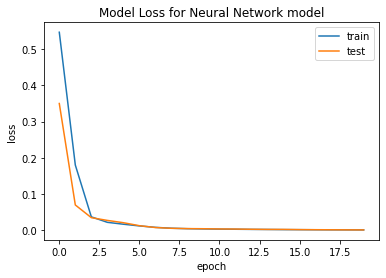

In [36]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss for Neural Network model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [37]:
# Prediction for test
predict = model.predict(X_test)
print(predict)

[[3.45645253e-06]
 [9.99931931e-01]
 [3.63877029e-06]
 ...
 [9.99993563e-01]
 [1.24573954e-17]
 [1.49024992e-17]]


In [38]:
classes = predict
#classes = predict.argmax(-1)
classes[classes <= 0.5] = 0
classes[classes > 0.5] = 1
print(classes)

[[0.]
 [1.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]


In [39]:
print('Accuracy: ' + "{:.4f}".format(accuracy_score(Y_test, classes)))
print('AUC: ' + "{:.4f}".format(roc_auc_score(Y_test, classes)))

Accuracy: 1.0000
AUC: 1.0000


In [22]:
# accuracy 
print (classification_report(Y_test, predict,digits = 6))
print (confusion_matrix(Y_test, predict))
print (accuracy_score(Y_test, predict))

              precision    recall  f1-score   support

           0   0.694675  0.762338  0.726935       770
           1   0.750681  0.681088  0.714193       809

    accuracy                       0.720709      1579
   macro avg   0.722678  0.721713  0.720564      1579
weighted avg   0.723370  0.720709  0.720407      1579

[[587 183]
 [258 551]]
0.7207093096896771


In [24]:
# Reading test data
test_data = pd.read_csv("../data_generated/test_data.csv", sep='\t')
test_data['Com_Followings_Ratio'] = test_data['Com_Followings_Ratio'].fillna(0)
test_data = test_data.replace([np.inf],1000)
# Normalization
test_data = (test_data-test_data.min())/(test_data.max()-test_data.min())
test_data = test_data.drop(columns=['Sink','Source','Distance'])

In [25]:
predict_test = model.predict(test_data)
predict_test 

array([[0.38563478],
       [0.47393203],
       [0.59878665],
       ...,
       [0.49051303],
       [0.48971367],
       [0.50681055]], dtype=float32)

In [26]:
prediction = pd.DataFrame([])
i = 0
for row in predict_test:
    i += 1
    prediction = prediction.append(pd.DataFrame({'Id': i, 'Predicted': row[0]},
                                                index=[0]), ignore_index=True) 
prediction.to_csv("../predictions/prediction_2020-09-17-1.csv", sep=',', index=False,float_format='%.8f')